<a href="https://colab.research.google.com/github/itaewonflow/lecture-DeepLearning/blob/main/Training%20Techniques%20Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning**
## **Train Techniques Practice**

---
**Intro:** Deep Learning 모델의 정확도를 높이기 위한 많은 기술적 배경이 있습니다. Learning Rate, Optimizer, Data Augumentation, Dropout와 같이 많이 사용하는 기술적 사항들이 있는데요. 각 요소들이 모델에 어떤 영향을 미치는지 프로그램을 통해 알아보도록 하겠습니다.

다양한 학습을 많이 돌려보기 위해 CIFAR10보다는 쉽고 MNIST보다는 어려운 **Fashion MNIST** 데이터를 사용하겠습니다.

#**Data Introduce : Fashion MNIST**
Fashion MNIST는 MNIST와 같은 포멧이지만 데이터 이미지와 클래스가 의류인 데이터셋입니다. 전체 데이터셋은 28x28크기의 흑백 이미지 60000장으로 50000장의 Train dataset과, 10000장의 Test dataset으로 이루어져 있습니다. 또한 10개의 클래스를 가지고 있는점은 MNIST와 같습니다.


---


10개의 레이블은 다음과 같습니다.
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot


Github MNIST Fashion
: https://github.com/zalandoresearch/fashion-mnist

#**Programming Part for Fashion MNIST**

In [20]:
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np

import matplotlib.pyplot as plt

##**Coding Explanation**

###**Data Set Loding**
- **line 01] datasets.FashionMNIST** : torchvision에서 제공하는 dataset에 Fashion MNIST를 제공하고 있어 데이타 로딩이 손쉽게 가능합니다.
- **line 03] fmnist[i][0]** : 0번이 이미지, 1번은 레이블로 이미지만 로딩합니다.
- **line 04] make_grid** : 텐서 형태의 이미지를 그리드 형태로 변환합니다.

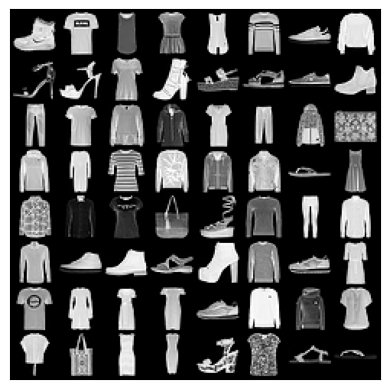

In [21]:
fmnist = datasets.FashionMNIST(root='fmnist', train=True, download=True, transform=transforms.ToTensor())

samples = [fmnist[i][0] for i in range(8*8)]
imgs = utils.make_grid(samples)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(imgs)

##**Coding Explanation**

###**Model**
- 간단한 데이터셋인 만큼 간단한 모델로 실습을 진행해 봅니다. **<font color=red>3개의 Convolution Layer, 3개의 MaxPool, 1개의 FC Layer를 사용한 모델</font>**로 구현합니다.
- **line 05**] _make_layer(1, 8)** : 흑백이미지이기 때문에 1부터 시작한다.
- **line 08**] nn.Linear(32, num_classes) ** : 10개의 class이기 때문에 10개로 분류하고 출력하는 Layer를 만듭니다.
- **line 23**] F.adaptive_avg_pool2d(out, (1, 1))** : adaptive_avg_pool2d은 avg pooling을 수행하는데, 커널과 스트라이드를 지정하는 이전 방법에 비해, output size만 지정하면 자체적으로 커널사이즈와 스트라이드를 계산하여 셋팅하는 기능을 제공합니다.



In [22]:
class MyNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MyNet, self).__init__()

        self.layer1 = self._make_layer(1, 8)
        self.layer2 = self._make_layer(8, 16)
        self.layer3 = self._make_layer(16, 32)
        self.linear = nn.Linear(32, num_classes)

    def _make_layer(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, (1, 1)) # 32x1x1
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [23]:
print(MyNet())

MyNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=32, out_features=10, bias=True)
)


## **Baseline 학습하기**

- 모든 실험에서 **가장 중요한 것은 Baseline 즉 기준점을 잡는 것입니다**. Baseline을 먼저 정한후에 다음에 진행하는 실험이 Baseline보다 얼마나 좋아졌는지를 비교해가면서 실험을 진행해야 현재 내가 얼마나 잘하고 있는지를 계속 비교하면서 실험해 나아갈 수 있습니다.

- 본 진행에서는 아래와 같이 Baseline을 정하겠습니다.

| Hyperprams Name | Value |
| --------------- | ----------------------------- |
| Model | MyNet |
| Epochs | 10 |
| BatchSize | 128 |
| Loss | Cross Entropy |
| Optimizer | Adam |
| Learning Rate | 0.001 |

In [24]:
is_cuda = torch.cuda.is_available()   # GPU가 사용가능한지
device = torch.device("cuda" if is_cuda else "cpu") # GPU가 사용가능하다면 GPU를 사용 아니면 CPU 사용
print(is_cuda, device)

True cuda


In [25]:
seed = 1010
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

##**Coding Explanation**

### **Data Loader Part**

In [26]:
from torch.utils.data import random_split


def get_fmnist_dataloaders(batch_size, val=0.2, num_workers=0):
  # transform
  transform = transforms.Compose([
    transforms.ToTensor(),
  ])

  # split                       v FashinMNIST 불러오기
  mnist_train_origin = datasets.FashionMNIST(root='fmnist', train=True, download=True, transform=transform)
  val_samples = int(len(mnist_train_origin) * val)
  train_samples = len(mnist_train_origin) - val_samples

  # dataset
  mnist_train, mnist_val = random_split(mnist_train_origin, (train_samples, val_samples))
  mnist_test = datasets.FashionMNIST(root='fmnist', train=False, download=True, transform=transform)

  # dataloader
  train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_loader = DataLoader(dataset=mnist_val, batch_size=batch_size, num_workers=num_workers)
  test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, num_workers=num_workers)

  return train_loader, val_loader, test_loader

##**Coding Explanation**

### **Loding Train Part**

In [27]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  for i, (data, targets) in enumerate(dataloader):
    data, targets = data.to(device), targets.to(device)   # data device로 이동

    optimizer.zero_grad()       # gradient 초기화
    outputs = model(data)       # forward
    loss = criterion(outputs, targets)    # loss 계산
    loss.backward()             # gradient 계산
    optimizer.step()            # weight update

    running_loss += loss.item()

    # Accuracy 계산
    _, predicted = torch.max(outputs, 1)
    correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 출력
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f"[{epoch}] train loss: {running_loss/len(dataloader):.4f} train acc: {correct}/{data_num} ({acc:.2f}%)")

  return running_loss/len(dataloader), acc

##**Coding Explanation**

### **Validation Part**

In [28]:
def validation(model, dataloader, criterion, epoch, device):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with torch.no_grad():   # gradient 계산 안하기
    for i, (data, targets) in enumerate(dataloader):
      data, targets = data.to(device), targets.to(device)   # data device로 이동

      outputs = model(data)               # forward
      loss = criterion(outputs, targets)  # loss 계산

      running_loss += loss.item()

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader), acc

##**Coding Explanation**

### **Loding Test Part**

In [29]:
def test(model, dataloader, device):
  # eval 모드
  model.eval()

  # 테스트 통계
  correct = 0

  with torch.no_grad():
    for data, targets in dataloader:
      data, targets = data.to(device), targets.to(device)

      outputs = model(data)    # forward

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

##**Coding Explanation**

### **Execution Training Data**

- 약 5분 실행

In [30]:
# Hyperparameters
# Training
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.001

checkpoint = None

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

start_epoch = 0

# load
if checkpoint is not None:
  ckpt = torch.load(checkpoint)
  model.load_state_dict(ckpt["model"])
  optimizer.load_state_dict(ckpt["optimizer"])
  start_epoch = ckpt["epoch"] + 1
  print("Model Loaded:", checkpoint)
  print("Last Epoch:", start_epoch, f"loss: {ckpt['loss']:.4f}", )

# Start Training
train_losses = []
val_losses = []

for epoch in range(start_epoch, EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, tacc = validation(model, val_loader, criterion, epoch, device)

  train_losses.append(tloss)
  val_losses.append(vloss)

test(model, test_loader, device)

[0] train loss: 0.9851 train acc: 34271/48000 (71.40%)
[0] valid loss: 0.6181 valid acc: 9410/12000 (78.42%)

[1] train loss: 0.5056 train acc: 39783/48000 (82.88%)
[1] valid loss: 0.4849 valid acc: 10055/12000 (83.79%)

[2] train loss: 0.4170 train acc: 41106/48000 (85.64%)
[2] valid loss: 0.4262 valid acc: 10242/12000 (85.35%)

[3] train loss: 0.3735 train acc: 41698/48000 (86.87%)
[3] valid loss: 0.3847 valid acc: 10386/12000 (86.55%)

[4] train loss: 0.3444 train acc: 42168/48000 (87.85%)
[4] valid loss: 0.3570 valid acc: 10500/12000 (87.50%)

[5] train loss: 0.3229 train acc: 42505/48000 (88.55%)
[5] valid loss: 0.3837 valid acc: 10363/12000 (86.36%)

[6] train loss: 0.3091 train acc: 42743/48000 (89.05%)
[6] valid loss: 0.3232 valid acc: 10684/12000 (89.03%)

[7] train loss: 0.2975 train acc: 42862/48000 (89.30%)
[7] valid loss: 0.3351 valid acc: 10561/12000 (88.01%)

[8] train loss: 0.2874 train acc: 43059/48000 (89.71%)
[8] valid loss: 0.3398 valid acc: 10584/12000 (88.20%)

[9

##**Into the Real Practice**

- 지금까지는 하나의 모델에 하나의 실험만 진행했지만 좋은 모델은 한번의 학습으로 만들어지지 않습니다. 여러가지 파라미터를 변경하며 진행하는 실험에서 좋은 학습모델이 만들어지게 됩니다.
- 이런 경우 매번 실험에서 어떤 하이퍼파라미터를 사용했는지 로그는 어땠는지를 남기는 작업이 필요한데요. 이를 위해 <u>**실험관리**</u>라는 개념이 필요해졌습니다. 다양한 실험관리 툴들이 있지만 쉽고 많이 사용되는 **<u>Tensorboard를 이용해서 실험관리 및 로깅하는 방법</u>**을 알아보겠습니다.
- Tensorboard는 원래 Tensorflow에서 만들어진 실험관리 및 로깅 도구로 스칼라 값 뿐 아니라 이미지, 임베딩, 오디오등 다양한 값을 로깅할 수 있습니다. Pytorch에서도 직접 실험관리 및 로깅툴을 만드려는 시도가 있었지만 Tensorboard에 기록할수 있는 기능이 추가되면서 Tensorboard가 널리 사용되게 되었습니다.
- Tensorboard 를 사용하기 위해서 몇가지 코드를 수정하겠습니다.

##**Coding Explanation**

### **TensorBoard Adaption**

- **line 02**] SummaryWriter : TensorBoard를 적용하기 위한 Library
- **line 05**] LOGGING_ROOT : Log를 저장할 위치
- **line 27**] SummaryWriter : TensorBoard에 저장을 한다. add_scalars를 통해 각 내용을 저장한다.
- **line 36**] add_scalars : 중요한 내용으로 epoch을 지정한다. 각 epoch마다 결과를 저장하기 위함이다.
- **line 38**] flush : add_scalars가 되자마자 결과를 파일에 저장하기 위한 명령어



In [31]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

LOGGING_ROOT = '/content/drive/MyDrive/Colab Notebooks/ch5/runs/'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
EXP = 'Baseline_{}'.format(timestamp)

# Hyperparameters
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.001

# Model
model = MyNet()
model = model.to(device)

# MNIST dataloader
train_loader, val_loader, test_loader = get_fmnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Logging
writer = SummaryWriter(LOGGING_ROOT + EXP)

# Start Training
for epoch in range(EPOCH):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  # train_losses.append(tloss)
  # val_losses.append(vloss)
  writer.add_scalars('Loss', { 'train' : tloss, 'valid' : vloss }, epoch + 1)
  writer.add_scalars('Accuracy', { 'train' : tacc, 'valid' : vacc }, epoch + 1)
  writer.flush()

test(model, test_loader, device)

[0] train loss: 1.0213 train acc: 33380/48000 (69.54%)
[0] valid loss: 0.6269 valid acc: 9414/12000 (78.45%)

[1] train loss: 0.5272 train acc: 39307/48000 (81.89%)
[1] valid loss: 0.5009 valid acc: 9864/12000 (82.20%)

[2] train loss: 0.4331 train acc: 40668/48000 (84.72%)
[2] valid loss: 0.4476 valid acc: 10098/12000 (84.15%)

[3] train loss: 0.3871 train acc: 41477/48000 (86.41%)
[3] valid loss: 0.3883 valid acc: 10319/12000 (85.99%)

[4] train loss: 0.3562 train acc: 41954/48000 (87.40%)
[4] valid loss: 0.3727 valid acc: 10353/12000 (86.28%)

[5] train loss: 0.3354 train acc: 42320/48000 (88.17%)
[5] valid loss: 0.3707 valid acc: 10396/12000 (86.63%)

[6] train loss: 0.3196 train acc: 42534/48000 (88.61%)
[6] valid loss: 0.3339 valid acc: 10529/12000 (87.74%)

[7] train loss: 0.3076 train acc: 42744/48000 (89.05%)
[7] valid loss: 0.3561 valid acc: 10484/12000 (87.37%)

[8] train loss: 0.2970 train acc: 42903/48000 (89.38%)
[8] valid loss: 0.3006 valid acc: 10706/12000 (89.22%)

[9]

### **TensorBoard Usage**


In [34]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=5ee1b4566032a09589a4c3bd0967bf07563ae7ad81dfb6c5d82785e817a6e4cf
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [40]:
%load_ext tensorboard
%tensorboard --load_fast=false --port=6006 --logdir LOGGING_ROOT

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-10-09 09:57:01.702343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.